# Classifiers - busy vs relaxed - with TFv1
Exploring different classifiers with with the contractive autoencoder. It needs the TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Contractive Autoencoder](#Contractive-Autoencoder)  

classifiers:  
[Simple dense layer](#Simple-dense-layer)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# required for the contractive autoencoder
# need to disable eager execution for .get_weights() in contractive autoencoder loss to work
tf.compat.v1.disable_eager_execution()
import tensorflow.keras.backend as K
import json
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn.model_selection import RandomizedSearchCV

import warnings

import talos
from talos.utils import lr_normalizer

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']#,
#            keras.metrics.TruePositives(),
#            keras.metrics.FalsePositives(),
#            keras.metrics.TrueNegatives(),
#            keras.metrics.FalseNegatives()]

In [2]:
# from https://github.com/ageron/handson-ml/blob/master/extra_tensorflow_reproducibility.ipynb
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                        inter_op_parallelism_threads=1)

with tf.compat.v1.Session(config=config) as sess:
    #... this will run single threaded
    pass

In [3]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [4]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 when starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [5]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [6]:
def get_busy_vs_relax_timeframes_br_hb(path, ident, seconds):
    """Returns raw data from either 'on task' or 'relax' time frames and their class (0 or 1)."""
    
    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    relax_n = dataread.get_relax_timestamps(return_indexes=True)

    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))

        ### task versus relax (1 sample each)
        dataextract = dataextractor.DataExtractor(data[0][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  data[1][busy_n[task_num_table][0]:busy_n[task_num_table][1]],
                                                  samp_rate)

        dataextract_relax = dataextractor.DataExtractor(data[0][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        data[1][relax_n[task_num_table][0]:relax_n[task_num_table][1]],
                                                        samp_rate)

        try:

            # get extracted features for breathing
            tmpBR_busy = dataextract.extract_from_breathing_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpBR_relax = dataextract_relax.extract_from_breathing_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])
            #get extracted features for heartbeat
            tmpHB_busy = dataextract.extract_from_heartbeat_time(dataextract.t[-samp_rate*seconds:],
                                                                 dataextract.y[-samp_rate*seconds:])
            tmpHB_relax = dataextract.extract_from_heartbeat_time(dataextract_relax.t[-samp_rate*seconds:],
                                                                 dataextract_relax.y[-samp_rate*seconds:])

            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tasks_y, 1))
            tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
            tmp_tasks_y = np.vstack((tmp_tasks_y, 0))

            # put busy frames then relaxed frames under the previous frames
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_breathing = np.vstack((tmp_breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        except ValueError:
#             print(ident)  # ignore short windows
            continue

        # put busy frames then relaxed frames under the previous frames
        tasks_data = np.vstack((tasks_data, dataextract.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 1))
        tasks_data = np.vstack((tasks_data, dataextract_relax.y[-samp_rate * seconds:]))
        tasks_y = np.vstack((tasks_y, 0))

        breathing = np.vstack((breathing, tmpBR_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        breathing = np.vstack((breathing, tmpBR_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

        heartbeat = np.vstack((heartbeat, tmpHB_busy.to_numpy(dtype='float64', na_value=0)[0][:-1]))
        heartbeat = np.vstack((heartbeat, tmpHB_relax.to_numpy(dtype='float64', na_value=0)[0][:-1]))

    return tasks_data, tasks_y, breathing, heartbeat

In [7]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes

            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [8]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [9]:
def set_random_seeds():
    # clear session and set seeds again
    # cannot clear session due to tf.compat.v1 graphs, but add tf.compat.v1.set_random_seed
#     K.clear_session()
    tf.compat.v1.set_random_seed(2)
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [10]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [11]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with standard scaler
phase_all_train = scale(phase_all_train, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with standard scaler
phase_all_valid = scale(phase_all_valid, axis=1)
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [12]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [13]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [14]:
# AE Training params
batch_size = 256
epochs = 2000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [15]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Contractive Autoencoder
From: https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

In [16]:
# define a function to be able to access the autoencoder in the loss funciton
def loss_with_params(autoencoder):
    # loss function from https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/
    def contractive_loss(y_pred, y_true):

        lam = 1e-4
        mse = K.mean(K.square(y_true - y_pred), axis=1)

        W = K.variable(value=autoencoder.get_layer('encoded').get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = autoencoder.get_layer('encoded').output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return mse + contractive
    return contractive_loss

In [17]:
def contractive_ae(x, encoding_dim=64, encoded_as_model=False):
    # From https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

    input_data = Input(shape=x[0].shape, name="input")
    encoded = Dense(encoding_dim, activation='sigmoid', name='encoded')(input_data)
    outputs = Dense(x[0].shape[0], activation='linear', name="output")(encoded)

    autoencoder = Model(input_data, outputs, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss=loss_with_params(autoencoder), metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [18]:
set_random_seeds()
ct_ae, ct_enc = contractive_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
ct_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

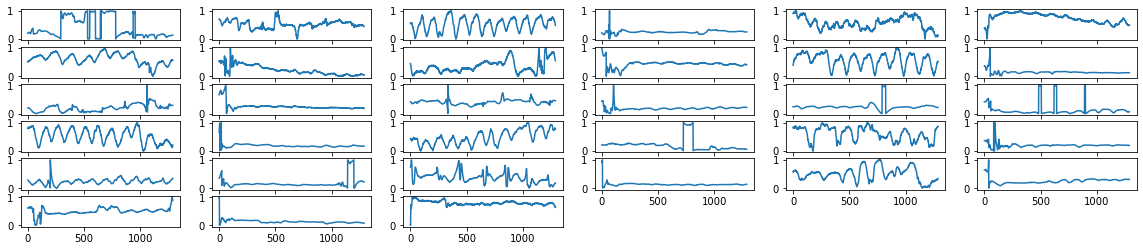

<Figure size 432x288 with 0 Axes>

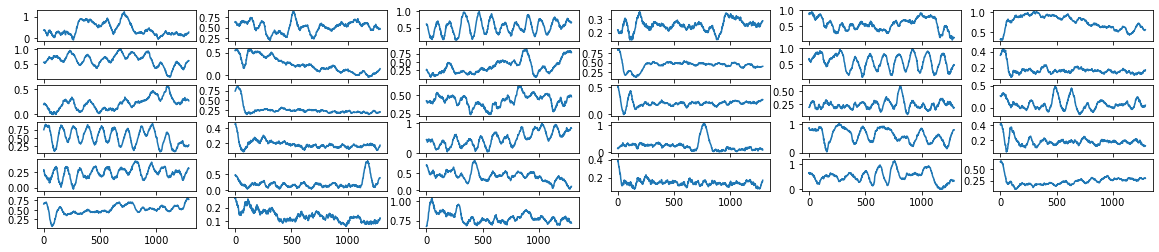

In [19]:
data2 = ct_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

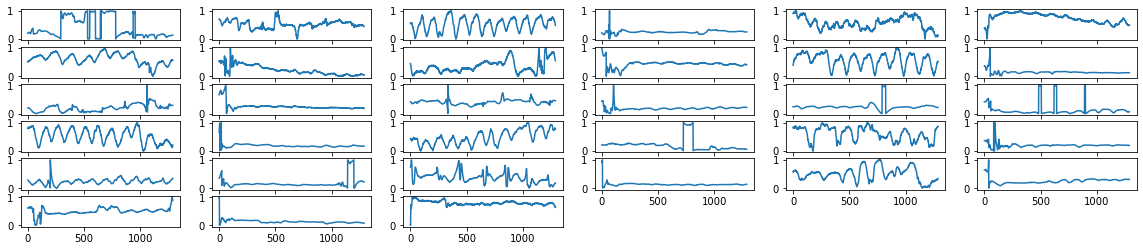

<Figure size 432x288 with 0 Axes>

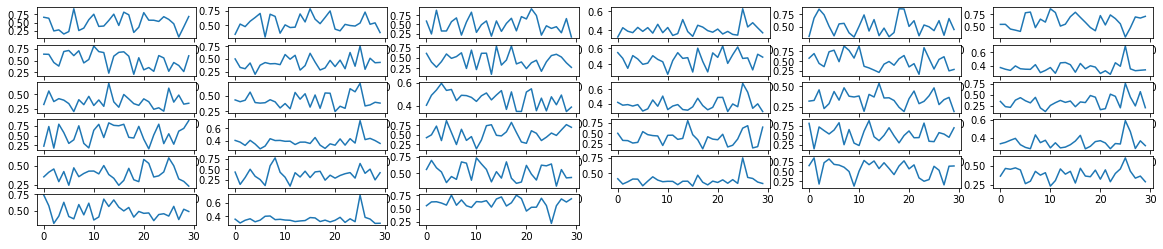

In [20]:
data2 = ct_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [21]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    ct_data = ct_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['contractive_encoded'] = ct_data

Helper function to get data from the dictionary:

In [22]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    contractive_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        y = np.vstack((y, data_dict[tmp_id]['y']))
        contractive_encoded = np.vstack((contractive_encoded, data_dict[tmp_id]['contractive_encoded']))
    
    return y, phase, contractive_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [24]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['contractive'] = []
    accs['test id'] = []
    start_time = datetime.now()

    with tf.compat.v1.Session(config=config) as sess:
        # leave out person out validation
        for i in range(n):

            # print current iteration and time elapsed from start
            print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

            ## ----- Data preparation:
            validation_idents = [idents[i]]
            test_idents = [idents[i-1]]

            train_idents = []
            for ident in idents:
                if (ident not in test_idents) and (ident not in validation_idents):
                    train_idents.append(ident)

            # save test id to see which id yielded which accuracies
            accs['test id'].append(test_idents[0])

            # Load train data
            train_data = get_ident_data_from_dict(train_idents, data_dict)
            y_train = train_data[0]

            # Load validation data
            valid_data = get_ident_data_from_dict(validation_idents, data_dict)
            y_valid = valid_data[0]

            # Load test data
            test_data = get_ident_data_from_dict(test_idents, data_dict)
            y_test = test_data[0]

            data_names_by_index = ['y', 'phase', 'contractive']

            # Loop over all data that will be used for classification and send it to the classifier
            # index 0 is y so we skip it
            for index in range(1, len(test_data)):
                set_random_seeds()
                train_x = train_data[index]
                valid_x = valid_data[index]
                test_x = test_data[index]

                # Scale data
                if should_scale_data:

                    # scale phase in a different way than other features
                    if (index == 1): 
                        # Scale each row with standard scaler
                        train_x = scale(train_x, axis=1)
                        valid_x = scale(valid_x, axis=1)
                        test_x = scale(test_x, axis=1)
                        # Scale each row with MinMax to range [0,1]
                        train_x = MinMaxScaler().fit_transform(train_x.T).T
                        valid_x = MinMaxScaler().fit_transform(valid_x.T).T
                        test_x = MinMaxScaler().fit_transform(test_x.T).T
                    else:
                        # Scale with standard scaler
                        sscaler = StandardScaler()
                        sscaler.fit(train_x)
                        train_x = sscaler.transform(train_x)

                        # Scale with MinMax to range [0,1]
                        mmscaler = MinMaxScaler((0,1))
                        mmscaler.fit(train_x)
                        train_x = mmscaler.transform(train_x)

                        # Scale valid and test with train's scalers
                        valid_x = sscaler.transform(valid_x)
                        valid_x = mmscaler.transform(valid_x)

                        test_x = sscaler.transform(test_x)
                        test_x = mmscaler.transform(test_x)
                
                # Initialize variables
                tmp_acc = []
                data_name = data_names_by_index[index]

                for index in range(num_loops_to_average_over):
                    curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                    tmp_acc.append(curr_acc)

                # Store accuracy
                curr_acc = np.mean(tmp_acc)
                accs[data_name].append(curr_acc)


        # Print total time required to run this
        end_time = datetime.now()
        elapsed_time = end_time - start_time
        print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [25]:
params = {
    'dropout': 0.24,
    'optimizer': 'Adam',
    'hidden_size': 64,
    'loss': 'binary_crossentropy',
    'last_activation': 'sigmoid',
    'activation': 'softmax',
    'batch_size': 256,
    'epochs': 100
}

In [26]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    
    # Define the model
    model = Sequential()
    model.add(Dropout(0))
    model.add(Dense(32))
    model.add(Activation('sigmoid'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [27]:
accs = helper_loop(dense_train, idents, n=n, num_loops_to_average_over=3, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.006980
iteration: 2 of 23 ; time elapsed: 0:00:13.361478
iteration: 3 of 23 ; time elapsed: 0:00:27.276375
iteration: 4 of 23 ; time elapsed: 0:00:42.598523
iteration: 5 of 23 ; time elapsed: 0:00:59.706990
iteration: 6 of 23 ; time elapsed: 0:01:17.941258
iteration: 7 of 23 ; time elapsed: 0:01:37.657761
iteration: 8 of 23 ; time elapsed: 0:01:58.644600
iteration: 9 of 23 ; time elapsed: 0:02:21.161637
iteration: 10 of 23 ; time elapsed: 0:02:45.169206
iteration: 11 of 23 ; time elapsed: 0:03:09.746123
iteration: 12 of 23 ; time elapsed: 0:03:35.971099
iteration: 13 of 23 ; time elapsed: 0:04:03.597191
iteration: 14 of 23 ; time elapsed: 0:04:32.682790
iteration: 15 of 23 ; time elapsed: 0:05:03.708132
iteration: 16 of 23 ; time elapsed: 0:05:35.825848
iteration: 17 of 23 ; time elapsed: 0:06:09.690907
iteration: 18 of 23 ; time elapsed: 0:06:44.958567
iteration: 19 of 23 ; time elapsed: 0:07:22.398246
iteration: 20 of 23 ; time elapsed: 0:08

In [28]:
accuracies['simple_dense'] = accs

In [29]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.722222,0.513889,62i9y
1,0.598039,0.627451,2gu87
2,0.611111,0.527778,iz2ps
3,0.588235,0.480392,1mpau
4,0.522222,0.588889,7dwjy
5,0.729167,0.593750,7swyk
6,0.604167,0.562500,94mnx
7,0.544445,0.477778,bd47a
8,0.500000,0.655556,c24ur
9,0.622222,0.544445,ctsax


In [30]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.431373     0.372549
max     0.770833     0.655556
mean    0.579982     0.523445
median  0.552083     0.527778


#### LSTM-based classifier  
based on the original author's code

In [31]:
params_phase = {
    'kernel_size': 4,
    'filters': 64,
    'strides': 4,
    'pool_size': 4,
    'dropout': 0.09,
    'lstm_output_size': 256,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 128,
    'epochs': 100
}

In [32]:
params_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.09,
    'lstm_output_size': 8,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': 'Nadam',
    'batch_size': 64,
    'epochs': 100
}

In [33]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    # change parameters based on which data this gets
    # because phase data has more values so some parameters can be larger (e.g. kernel)
    params = params_br_hb
    if (data_name == 'phase'):
        params = params_phase
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'],
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [34]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00.005983
iteration: 2 of 23 ; time elapsed: 0:01:10.213050
iteration: 3 of 23 ; time elapsed: 0:02:18.687759
iteration: 4 of 23 ; time elapsed: 0:03:29.349914
iteration: 5 of 23 ; time elapsed: 0:04:41.811305
iteration: 6 of 23 ; time elapsed: 0:05:57.467142
iteration: 7 of 23 ; time elapsed: 0:07:18.071743
iteration: 8 of 23 ; time elapsed: 0:08:39.105078
iteration: 9 of 23 ; time elapsed: 0:10:03.001115
iteration: 10 of 23 ; time elapsed: 0:11:29.854701
iteration: 11 of 23 ; time elapsed: 0:12:58.425457
iteration: 12 of 23 ; time elapsed: 0:14:38.098993
iteration: 13 of 23 ; time elapsed: 0:16:13.702077
iteration: 14 of 23 ; time elapsed: 0:17:48.153200
iteration: 15 of 23 ; time elapsed: 0:19:25.227330
iteration: 16 of 23 ; time elapsed: 0:21:06.470419
iteration: 17 of 23 ; time elapsed: 0:22:52.345070
iteration: 18 of 23 ; time elapsed: 0:24:39.604314
iteration: 19 of 23 ; time elapsed: 0:26:36.791333
iteration: 20 of 23 ; time elapsed: 0:28

In [35]:
accuracies['LSTM'] = accs

In [36]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.791667,0.583333,62i9y
1,0.647059,0.529412,2gu87
2,0.861111,0.472222,iz2ps
3,0.764706,0.441176,1mpau
4,0.666667,0.533333,7dwjy
5,0.812500,0.656250,7swyk
6,0.718750,0.437500,94mnx
7,0.766667,0.566667,bd47a
8,0.833333,0.400000,c24ur
9,0.633333,0.466667,ctsax


In [37]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.531250     0.352941
max     0.861111     0.823529
mean    0.723279     0.532527
median  0.750000     0.529412


#### kNN

In [38]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier():
    model = KNeighborsClassifier(p=3, n_neighbors=7, metric='cosine')
    return model

In [39]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = KNN_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [40]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00.006627
iteration: 2 of 23 ; time elapsed: 0:00:00.139256
iteration: 3 of 23 ; time elapsed: 0:00:00.256970
iteration: 4 of 23 ; time elapsed: 0:00:00.369668
iteration: 5 of 23 ; time elapsed: 0:00:00.481369
iteration: 6 of 23 ; time elapsed: 0:00:00.596034
iteration: 7 of 23 ; time elapsed: 0:00:00.700783
iteration: 8 of 23 ; time elapsed: 0:00:00.808517
iteration: 9 of 23 ; time elapsed: 0:00:00.916884
iteration: 10 of 23 ; time elapsed: 0:00:01.035596
iteration: 11 of 23 ; time elapsed: 0:00:01.160494
iteration: 12 of 23 ; time elapsed: 0:00:01.279745
iteration: 13 of 23 ; time elapsed: 0:00:01.395813
iteration: 14 of 23 ; time elapsed: 0:00:01.522474
iteration: 15 of 23 ; time elapsed: 0:00:01.642219
iteration: 16 of 23 ; time elapsed: 0:00:01.793464
iteration: 17 of 23 ; time elapsed: 0:00:01.900112
iteration: 18 of 23 ; time elapsed: 0:00:02.006577
iteration: 19 of 23 ; time elapsed: 0:00:02.125011
iteration: 20 of 23 ; time elapsed: 0:00

In [41]:
accuracies['kNN'] = accs

In [42]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.458333,0.541667,62i9y
1,0.705882,0.588235,2gu87
2,0.611111,0.527778,iz2ps
3,0.705882,0.676471,1mpau
4,0.666667,0.700000,7dwjy
5,0.812500,0.718750,7swyk
6,0.562500,0.500000,94mnx
7,0.600000,0.533333,bd47a
8,0.666667,0.466667,c24ur
9,0.600000,0.733333,ctsax


In [43]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.458333     0.466667
max     0.812500     0.733333
mean    0.634879     0.585674
median  0.617647     0.562500


####  SVC

In [44]:
from sklearn.svm import SVC

def SVC_classifier():
    model = SVC(kernel='rbf', C=1.5)
    return model

In [45]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = SVC_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [46]:
accs = helper_loop(SVC_train, idents, n=n, num_loops_to_average_over=5)

iteration: 1 of 23 ; time elapsed: 0:00:00.007976
iteration: 2 of 23 ; time elapsed: 0:00:03.292463
iteration: 3 of 23 ; time elapsed: 0:00:06.458888
iteration: 4 of 23 ; time elapsed: 0:00:09.576165
iteration: 5 of 23 ; time elapsed: 0:00:12.653150
iteration: 6 of 23 ; time elapsed: 0:00:15.814288
iteration: 7 of 23 ; time elapsed: 0:00:19.049179
iteration: 8 of 23 ; time elapsed: 0:00:22.133150
iteration: 9 of 23 ; time elapsed: 0:00:25.320467
iteration: 10 of 23 ; time elapsed: 0:00:28.528702
iteration: 11 of 23 ; time elapsed: 0:00:31.646469
iteration: 12 of 23 ; time elapsed: 0:00:34.794884
iteration: 13 of 23 ; time elapsed: 0:00:37.885611
iteration: 14 of 23 ; time elapsed: 0:00:40.994451
iteration: 15 of 23 ; time elapsed: 0:00:44.182424
iteration: 16 of 23 ; time elapsed: 0:00:47.269854
iteration: 17 of 23 ; time elapsed: 0:00:50.334214
iteration: 18 of 23 ; time elapsed: 0:00:53.417805
iteration: 19 of 23 ; time elapsed: 0:00:56.556472
iteration: 20 of 23 ; time elapsed: 0:00

In [47]:
accuracies['SVC'] = accs

In [48]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.708333,0.625000,62i9y
1,0.617647,0.823529,2gu87
2,0.777778,0.833333,iz2ps
3,0.617647,0.470588,1mpau
4,0.600000,0.733333,7dwjy
5,0.843750,0.656250,7swyk
6,0.625000,0.625000,94mnx
7,0.600000,0.600000,bd47a
8,0.600000,0.533333,c24ur
9,0.733333,0.566667,ctsax


In [49]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.527778     0.470588
max     0.843750     0.833333
mean    0.666304     0.604412
median  0.647059     0.593750


#### Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier():
    model = RandomForestClassifier(n_estimators = 250,
                                     min_samples_split = 10,
                                     min_samples_leaf = 4,
                                     max_features = 'auto',
                                     max_depth = 90,
                                     bootstrap = True)
    return model

In [51]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = random_forest_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [52]:
accs = helper_loop(random_forest_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.006165
iteration: 2 of 23 ; time elapsed: 0:00:14.247995
iteration: 3 of 23 ; time elapsed: 0:00:28.131296
iteration: 4 of 23 ; time elapsed: 0:00:41.671588
iteration: 5 of 23 ; time elapsed: 0:00:55.002251
iteration: 6 of 23 ; time elapsed: 0:01:08.816045
iteration: 7 of 23 ; time elapsed: 0:01:22.471659
iteration: 8 of 23 ; time elapsed: 0:01:36.115015
iteration: 9 of 23 ; time elapsed: 0:01:49.711706
iteration: 10 of 23 ; time elapsed: 0:02:03.604535
iteration: 11 of 23 ; time elapsed: 0:02:17.283971
iteration: 12 of 23 ; time elapsed: 0:02:30.569267
iteration: 13 of 23 ; time elapsed: 0:02:43.931611
iteration: 14 of 23 ; time elapsed: 0:02:57.337745
iteration: 15 of 23 ; time elapsed: 0:03:10.860898
iteration: 16 of 23 ; time elapsed: 0:03:24.447135
iteration: 17 of 23 ; time elapsed: 0:03:37.863553
iteration: 18 of 23 ; time elapsed: 0:03:51.349053
iteration: 19 of 23 ; time elapsed: 0:04:05.165040
iteration: 20 of 23 ; time elapsed: 0:04

In [53]:
accuracies['random_forest'] = accs

In [54]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.758333,0.700000,62i9y
1,0.594118,0.705882,2gu87
2,0.738889,0.777778,iz2ps
3,0.700000,0.588235,1mpau
4,0.540000,0.626667,7dwjy
5,0.781250,0.675000,7swyk
6,0.550000,0.581250,94mnx
7,0.613333,0.513333,bd47a
8,0.740000,0.540000,c24ur
9,0.706667,0.680000,ctsax


In [55]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.493333     0.462500
max     0.864706     0.777778
mean    0.661942     0.631371
median  0.664706     0.626667


#### Naive Bayesian

In [56]:
from sklearn.naive_bayes import ComplementNB

def naive_bayesian_classifier():
    model = ComplementNB()
    return model

In [57]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [58]:
accs = helper_loop(naive_bayesian_train, idents, n=n, should_scale_data=True)

iteration: 1 of 23 ; time elapsed: 0:00:00.008603
iteration: 2 of 23 ; time elapsed: 0:00:00.104378
iteration: 3 of 23 ; time elapsed: 0:00:00.198127
iteration: 4 of 23 ; time elapsed: 0:00:00.290851
iteration: 5 of 23 ; time elapsed: 0:00:00.382606
iteration: 6 of 23 ; time elapsed: 0:00:00.475385
iteration: 7 of 23 ; time elapsed: 0:00:00.569674
iteration: 8 of 23 ; time elapsed: 0:00:00.660406
iteration: 9 of 23 ; time elapsed: 0:00:00.752195
iteration: 10 of 23 ; time elapsed: 0:00:00.844975
iteration: 11 of 23 ; time elapsed: 0:00:00.938031
iteration: 12 of 23 ; time elapsed: 0:00:01.032778
iteration: 13 of 23 ; time elapsed: 0:00:01.126726
iteration: 14 of 23 ; time elapsed: 0:00:01.218136
iteration: 15 of 23 ; time elapsed: 0:00:01.312425
iteration: 16 of 23 ; time elapsed: 0:00:01.402137
iteration: 17 of 23 ; time elapsed: 0:00:01.492867
iteration: 18 of 23 ; time elapsed: 0:00:01.582626
iteration: 19 of 23 ; time elapsed: 0:00:01.673290
iteration: 20 of 23 ; time elapsed: 0:00

In [59]:
accuracies['naive_bayesian'] = accs

In [60]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.416667,0.458333,62i9y
1,0.470588,0.676471,2gu87
2,0.500000,0.527778,iz2ps
3,0.588235,0.558824,1mpau
4,0.533333,0.566667,7dwjy
5,0.687500,0.437500,7swyk
6,0.531250,0.687500,94mnx
7,0.433333,0.500000,bd47a
8,0.533333,0.500000,c24ur
9,0.500000,0.466667,ctsax


In [61]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.323529      0.37500
max     0.705882      0.68750
mean    0.492471      0.50455
median  0.500000      0.50000


#### XGBoost

In [62]:
from xgboost import XGBClassifier

def XGBoost_classifier():
    model = XGBClassifier(n_estimators = 83)
    return model

In [63]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = XGBoost_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [64]:
accs = helper_loop(XGBoost_train, idents, n=n, num_loops_to_average_over=5, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00.013962
iteration: 2 of 23 ; time elapsed: 0:00:11.565153
iteration: 3 of 23 ; time elapsed: 0:00:20.468099
iteration: 4 of 23 ; time elapsed: 0:00:29.139919
iteration: 5 of 23 ; time elapsed: 0:00:38.174377
iteration: 6 of 23 ; time elapsed: 0:00:47.417120
iteration: 7 of 23 ; time elapsed: 0:00:56.599074
iteration: 8 of 23 ; time elapsed: 0:01:05.635423
iteration: 9 of 23 ; time elapsed: 0:01:14.775627
iteration: 10 of 23 ; time elapsed: 0:01:23.730135
iteration: 11 of 23 ; time elapsed: 0:01:32.593708
iteration: 12 of 23 ; time elapsed: 0:01:41.685573
iteration: 13 of 23 ; time elapsed: 0:01:50.813979
iteration: 14 of 23 ; time elapsed: 0:01:59.792073
iteration: 15 of 23 ; time elapsed: 0:02:08.829508
iteration: 16 of 23 ; time elapsed: 0:02:17.712440
iteration: 17 of 23 ; time elapsed: 0:02:26.632642
iteration: 18 of 23 ; time elapsed: 0:02:35.510916
iteration: 19 of 23 ; time elapsed: 0:02:44.523469
iteration: 20 of 23 ; time elapsed: 0:02

In [65]:
accuracies['XGBoost'] = accs

In [66]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,contractive,test id
0,0.625000,0.708333,62i9y
1,0.617647,0.588235,2gu87
2,0.666667,0.694444,iz2ps
3,0.735294,0.647059,1mpau
4,0.600000,0.600000,7dwjy
5,0.718750,0.750000,7swyk
6,0.625000,0.625000,94mnx
7,0.633333,0.400000,bd47a
8,0.566667,0.633333,c24ur
9,0.700000,0.600000,ctsax


In [67]:
# print some statistics for each method
print_accs_stats(accs)

           phase  contractive
min     0.466667     0.400000
max     0.735294     0.750000
mean    0.625753     0.596766
median  0.625000     0.600000


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [68]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  contractive
min     0.431373     0.372549
max     0.770833     0.655556
mean    0.579982     0.523445
median  0.552083     0.527778


----------- LSTM: -----------
           phase  contractive
min     0.531250     0.352941
max     0.861111     0.823529
mean    0.723279     0.532527
median  0.750000     0.529412


----------- kNN: -----------
           phase  contractive
min     0.458333     0.466667
max     0.812500     0.733333
mean    0.634879     0.585674
median  0.617647     0.562500


----------- SVC: -----------
           phase  contractive
min     0.527778     0.470588
max     0.843750     0.833333
mean    0.666304     0.604412
median  0.647059     0.593750


----------- random_forest: -----------
           phase  contractive
min     0.493333     0.462500
max     0.864706     0.777778
mean    0.661942     0.631371
median  0.664706     0.626667


----------- naive_bayesian: -----------
           phase  contractive
min  

Print all accuracies in table form:

In [69]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  contractive test id
0   0.722222     0.513889   62i9y
1   0.598039     0.627451   2gu87
2   0.611111     0.527778   iz2ps
3   0.588235     0.480392   1mpau
4   0.522222     0.588889   7dwjy
5   0.729167     0.593750   7swyk
6   0.604167     0.562500   94mnx
7   0.544445     0.477778   bd47a
8   0.500000     0.655556   c24ur
9   0.622222     0.544445   ctsax
10  0.676471     0.539216   dkhty
11  0.552083     0.552083   e4gay
12  0.531250     0.531250   ef5rq
13  0.477778     0.522222   f1gjp
14  0.666667     0.520833   hpbxa
15  0.518519     0.564815   pmyfl
16  0.583333     0.564815   r89k1
17  0.531250     0.500000   tn4vl
18  0.489583     0.427083   td5pr
19  0.431373     0.372549   gyqu9
20  0.549020     0.480392   fzchw
21  0.519608     0.401961   l53hg
22  0.770833     0.489583   3n2f9


LSTM:
       phase  contractive test id
0   0.791667     0.583333   62i9y
1   0.647059     0.529412   2gu87
2   0.861111     0.472222   iz2ps
3   0.764706     0.441176 